# Tosho Recommender (Training)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import fasttext as ft
import pickle
import gensim
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, save_model
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from model import *

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

## Load Data

In [5]:
text_hist_pd = pd.read_csv('data/text_hist_perm.csv.bz', sep='\t', compression='bz2')
text_hist_pd.shape

(33600, 5)

In [6]:
text_hist_pd.sample(3, random_state=1)

,book1,book2,book3,book4,label
17402,深い 霧 の たちこめる 漆 の 海 姿 なき 幽霊 船長 ゴースト キャプテン が 舵 を...,アイスダンス ペア 樹里 と 恵 は 初 出場 し 界 選手権 大会 で 大 喝采 を 浴び...,そろそろ 考え ちゃ 悩め ブタ シッタカブッタ は 人生 の 見え 方 を ていねい に ...,なぞなぞ 大好き の 妖怪 たち が 読者 に おもしろい なぞなぞ で いどみ 人気 の ...,1700233
9348,宗教 と は 国 と は 人間 へ の 深い まなざし が 捉え 青春 小説 の 新 境地 ...,わたし じゃ よ わ ー ん わ ー ん 学校 から の 帰り道 大きな 声 て い 清香 ...,担任 に 納得 の いか 絵 を 描か さ れ ユク は 傷つく 憧れ の 少女 に 励まさ...,ひな まつり に 愛花 の 家 で は お ばあちゃん だけ が つくれる ごちそう 肉まん...,1902265
32139,夜 の 星空 を 見 げた とき に 学校 で 習っ 星座 が 星座 の 名前 の 通り に...,界 の カエル と 日本 の カエル 200 種類 を カラー 写真 で 紹介 分布 や す...,現在 もっとも 謎 の 多い チョウ モンシロチョウ 最新 の 撮影 技術 と 研究 成果 ...,ほ 類 は虫類 ペット 家 ちく アニマル ウォッチング 絶滅 危機 動物 とじこみ 付録 ...,1400121


## Split into Train and Val

In [7]:
train_texts, val_texts, y_train, y_val = train_test_split(text_hist_pd.drop(['label'], axis=1),
                                                          text_hist_pd[['label']].values,
                                                          test_size = .2,
                                                          random_state=1234)

## Tokenize

In [8]:
# Limit on the number of word features to the top 20K features.
TOP_K = 20000

# Most books are within 500 word length
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, y_train, val_texts, y_val):
    # Create vocabulary with training texts.
    tokenizer = Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts['book1'])

    # Vectorize training and validation texts.
    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_trn_1 = pad_sequences(tokenizer.texts_to_sequences(train_texts['book1']), maxlen=MAX_SEQUENCE_LENGTH)
    x_trn_2 = pad_sequences(tokenizer.texts_to_sequences(train_texts['book2']), maxlen=MAX_SEQUENCE_LENGTH)
    x_trn_3 = pad_sequences(tokenizer.texts_to_sequences(train_texts['book3']), maxlen=MAX_SEQUENCE_LENGTH)
    x_trn_4 = pad_sequences(tokenizer.texts_to_sequences(train_texts['book4']), maxlen=MAX_SEQUENCE_LENGTH)
    x_val_1 = pad_sequences(tokenizer.texts_to_sequences(val_texts['book1']), maxlen=MAX_SEQUENCE_LENGTH)
    x_val_2 = pad_sequences(tokenizer.texts_to_sequences(val_texts['book2']), maxlen=MAX_SEQUENCE_LENGTH)
    x_val_3 = pad_sequences(tokenizer.texts_to_sequences(val_texts['book3']), maxlen=MAX_SEQUENCE_LENGTH)
    x_val_4 = pad_sequences(tokenizer.texts_to_sequences(val_texts['book4']), maxlen=MAX_SEQUENCE_LENGTH)
    
    return x_trn_1, x_trn_2, x_trn_3, x_trn_4, x_val_1, x_val_2, x_val_3, x_val_4, tokenizer.word_index, tokenizer

In [9]:
x_trn_1, x_trn_2, x_trn_3, x_trn_4, x_val_1, x_val_2, x_val_3, x_val_4, word_index, tokenizer = sequence_vectorize(train_texts, y_train, val_texts, y_val)

In [10]:
# number of vocabulary in the corpus
len(word_index)

13505

### Load FastText (Japanese)

In [16]:
ja_vecs = ft.load_model('model/cc.ja.300.bin')

In [17]:
ja_vecs.get_word_vector('あ').shape

(300,)

In [18]:
EMBEDDING_DIM = 300

## Load Book2Vec Vectors

In [11]:
b2v = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('model/book2vec', binary=False)

/opt/conda/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Use Book2Vec vectors as label

In [12]:
y_train_gru = []
for book_id in y_train:
    y_train_gru.append(b2v.get_vector(str(book_id[0])))

y_train_gru = np.array(y_train_gru)

In [13]:
y_val_gru = []
for book_id in y_val:
    y_val_gru.append(b2v.get_vector(str(book_id[0])))

y_val_gru = np.array(y_val_gru)

In [14]:
y_train.shape, y_train_gru.shape, y_val.shape, y_val_gru.shape

((26880, 1), (26880, 392), (6720, 1), (6720, 392))

## Model

### Embedding layer

In [19]:
embedding_matrix = np.zeros((TOP_K+1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < TOP_K:
        try:
            embedding_vector = ja_vecs.get_word_vector(word)
        except:
            embedding_vector = np.zeros(EMBEDDING_DIM)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Train Model

In [20]:
learning_rate=0.0044

word_id_1 = Input(shape=(None,))
word_id_2 = Input(shape=(None,))
word_id_3 = Input(shape=(None,))
word_id_4 = Input(shape=(None,))

max_sequence = x_trn_1.shape[1] if MAX_SEQUENCE_LENGTH > x_trn_1.shape[1] else MAX_SEQUENCE_LENGTH

model = gru_model(
                     embedding_dim=EMBEDDING_DIM,
                     dropout_rate=0.209,
                     rnn_unit=194,
                     input_shape=(max_sequence,),
                     num_features=TOP_K+1,
                     share_gru_weights_on_book=True,
                     use_attention_on_book=True,
                     use_attention_on_user=True,
                     use_batch_norm=False,
                     is_embedding_trainable=False,
                     final_activation='tanh',
                     final_dimension=b2v.vector_size,
                     embedding_matrix=embedding_matrix)

# Compile model
loss = 'cosine_similarity'

optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['cosine_similarity'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

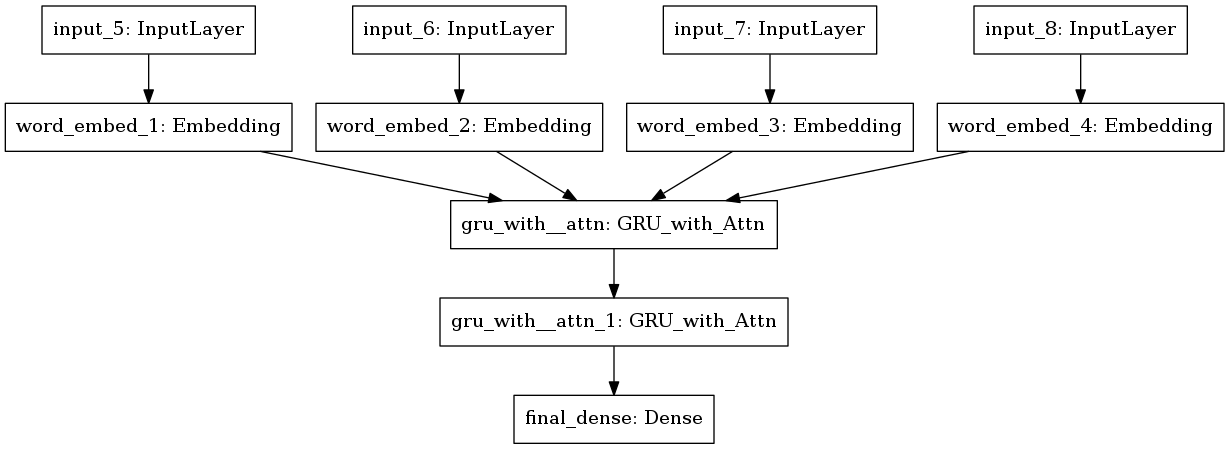

In [21]:
plot_model(model, to_file='img/tosho_recommender.png')

In [22]:
# Train
history = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_gru,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_gru),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 374s 14ms/sample - loss: -0.5412 - cosine_similarity: 0.5412 - val_loss: -0.6019 - val_cosine_similarity: 0.6019
Epoch 2/2
26880/26880 [==============================] - 328s 12ms/sample - loss: -0.6498 - cosine_similarity: 0.6498 - val_loss: -0.7164 - val_cosine_similarity: 0.7164


In [23]:
model.save_weights('model/tosho_recommender_1', save_format='tf')

In [24]:
# Train
history2 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_gru,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_gru),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 328s 12ms/sample - loss: -0.7270 - cosine_similarity: 0.7270 - val_loss: -0.7770 - val_cosine_similarity: 0.7770
Epoch 2/2
26880/26880 [==============================] - 331s 12ms/sample - loss: -0.7727 - cosine_similarity: 0.7727 - val_loss: -0.8153 - val_cosine_similarity: 0.8153


In [25]:
model.save_weights('model/tosho_recommender_2', save_format='tf')

In [26]:
# Train
history3 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_gru,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_gru),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 327s 12ms/sample - loss: -0.8025 - cosine_similarity: 0.8025 - val_loss: -0.8394 - val_cosine_similarity: 0.8394
Epoch 2/2
26880/26880 [==============================] - 328s 12ms/sample - loss: -0.8229 - cosine_similarity: 0.8229 - val_loss: -0.8571 - val_cosine_similarity: 0.8571


In [27]:
model.save_weights('model/tosho_recommender_3', save_format='tf')

In [28]:
# Train
history4 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_gru,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_gru),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 334s 12ms/sample - loss: -0.8372 - cosine_similarity: 0.8372 - val_loss: -0.8703 - val_cosine_similarity: 0.8703
Epoch 2/2
26880/26880 [==============================] - 324s 12ms/sample - loss: -0.8481 - cosine_similarity: 0.8481 - val_loss: -0.8785 - val_cosine_similarity: 0.8785


In [29]:
model.save_weights('model/tosho_recommender_4', save_format='tf')

In [30]:
# Train
history5 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_gru,
        epochs=2,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_gru),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/2
26880/26880 [==============================] - 331s 12ms/sample - loss: -0.8564 - cosine_similarity: 0.8564 - val_loss: -0.8858 - val_cosine_similarity: 0.8858
Epoch 2/2
26880/26880 [==============================] - 329s 12ms/sample - loss: -0.8628 - cosine_similarity: 0.8628 - val_loss: -0.8916 - val_cosine_similarity: 0.8916


In [31]:
model.save_weights('model/tosho_recommender_5', save_format='tf')

In [32]:
# Train
history6 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_gru,
        epochs=6,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_gru),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/6
26880/26880 [==============================] - 328s 12ms/sample - loss: -0.8683 - cosine_similarity: 0.8683 - val_loss: -0.8969 - val_cosine_similarity: 0.8969
Epoch 2/6
26880/26880 [==============================] - 323s 12ms/sample - loss: -0.8725 - cosine_similarity: 0.8725 - val_loss: -0.8997 - val_cosine_similarity: 0.8997
Epoch 3/6
26880/26880 [==============================] - 332s 12ms/sample - loss: -0.8766 - cosine_similarity: 0.8766 - val_loss: -0.9040 - val_cosine_similarity: 0.9040
Epoch 4/6
26880/26880 [==============================] - 326s 12ms/sample - loss: -0.8804 - cosine_similarity: 0.8804 - val_loss: -0.9065 - val_cosine_similarity: 0.9065
Epoch 5/6
26880/26880 [==============================] - 325s 12ms/sample - loss: -0.8831 - cosine_similarity: 0.8831 - val_loss: -0.9091 - val_cosine_similarity: 0.9091
Epoch 6/6
26880/26880 [==============================] - 329s 12ms/sample - loss: -0.8859 - cosine_si

In [33]:
model.save_weights('model/tosho_recommender_6', save_format='tf')

In [34]:
# Train
history7 = model.fit(
        [x_trn_1, x_trn_2, x_trn_3, x_trn_4],
        y_train_gru,
        epochs=6,
        validation_data=([x_val_1, x_val_2, x_val_3, x_val_4], y_val_gru),
        verbose=1,
        batch_size=256)

Train on 26880 samples, validate on 6720 samples
Epoch 1/6
26880/26880 [==============================] - 327s 12ms/sample - loss: -0.8882 - cosine_similarity: 0.8882 - val_loss: -0.9133 - val_cosine_similarity: 0.9133
Epoch 2/6
26880/26880 [==============================] - 320s 12ms/sample - loss: -0.8900 - cosine_similarity: 0.8900 - val_loss: -0.9147 - val_cosine_similarity: 0.9147
Epoch 3/6
26880/26880 [==============================] - 312s 12ms/sample - loss: -0.8923 - cosine_similarity: 0.8923 - val_loss: -0.9165 - val_cosine_similarity: 0.9165
Epoch 4/6
26880/26880 [==============================] - 313s 12ms/sample - loss: -0.8940 - cosine_similarity: 0.8940 - val_loss: -0.9177 - val_cosine_similarity: 0.9177
Epoch 5/6
26880/26880 [==============================] - 311s 12ms/sample - loss: -0.8958 - cosine_similarity: 0.8958 - val_loss: -0.9195 - val_cosine_similarity: 0.9195
Epoch 6/6
26880/26880 [==============================] - 311s 12ms/sample - loss: -0.8972 - cosine_si

In [35]:
model.save_weights('model/tosho_recommender_7', save_format='tf')

In [36]:
train_metrics = 'cosine_similarity'
train_metrics_concat = history.history[train_metrics] + history2.history[train_metrics] + history3.history[train_metrics] + history4.history[train_metrics] + history5.history[train_metrics]  + history6.history[train_metrics]  + history7.history[train_metrics] 
val_metrics = 'val_cosine_similarity'
val_metrics_concat = history.history[val_metrics] + history2.history[val_metrics] + history3.history[val_metrics] + history4.history[val_metrics] + history5.history[val_metrics] + history6.history[val_metrics] + history7.history[val_metrics] 

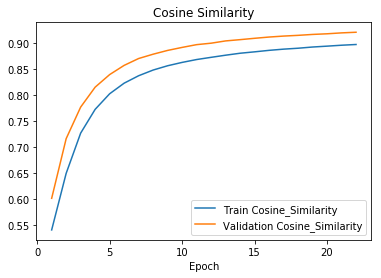

In [37]:
epoch_list = [i+1 for i in range(22)]

plt.figure(figsize = (6, 4))
plt.plot(epoch_list, train_metrics_concat, label='Train Cosine_Similarity')
plt.plot(epoch_list, val_metrics_concat, label='Validation Cosine_Similarity')
plt.title('Cosine Similarity')
plt.xlabel('Epoch')
plt.legend()
plt.show();

### Save Objects

In [38]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, protocol=2)

save_object(word_index, 'model/tosho_recommender_word_index.pkl')
save_object(tokenizer, 'model/tosho_recommender_word_tokenizer.pkl')

## Spot check

In [42]:
# Get book descriptions
text_pd = pd.read_csv('data/tosho_processed_clean.csv.bz2', sep='\t', compression='bz2')

text_dict = dict(zip(text_pd.id, text_pd.description_token))

label_dict = {}
for book_id in text_pd.id.unique().tolist():
    label_dict[book_id] = text_dict[book_id]

In [97]:
def recommend_book(book_list:list=None):
    if book_list:
        book_vec = model.predict(book_list)
    else:
        random_int =random.randint(0, x_val_1.shape[0]-1)
        book_vec = model.predict([np.expand_dims(x_val_1[random_int], axis=0), np.expand_dims(x_val_2[random_int], axis=0), np.expand_dims(x_val_3[random_int], axis=0), np.expand_dims(x_val_4[random_int], axis=0)])
    book_w2v_result = b2v.similar_by_vector(book_vec[0], topn=3)
                  
    similar_book_id_1 = book_w2v_result[0][0]
    similar_book_desc_1 = label_dict[int(similar_book_id_1)]
    similar_book_id_2 = book_w2v_result[1][0]
    similar_book_desc_2 = label_dict[int(similar_book_id_2)]
    similar_book_id_3 = book_w2v_result[2][0]
    similar_book_desc_3 = label_dict[int(similar_book_id_3)]

    if not book_list:
        print("Book History:")
        print(val_texts[random_int:random_int+1].values)
        print("\n")
    print("1st similar book ID: {}".format(similar_book_id_1))
    print("1st similar book description: {}".format(similar_book_desc_1))
    print("\n")
    print("2nd similar book ID: {}".format(similar_book_id_2))
    print("2nd similar book description: {}".format(similar_book_desc_2))
    print("\n")
    print("3rd similar book ID: {}".format(similar_book_id_3))
    print("3rd similar book description: {}".format(similar_book_desc_3))
    print("\n")
    print("word2vec result: {}".format(book_w2v_result))

In [45]:
# animal-related
recommend_book()

Book History:
[['最終 学年 を 迎え 私 は 卒論 の テーマ 芥川 介 を 掘り げ て いく かたわら 出版 社 で 初めて の アルバイト を 経験 する その 縁 あっ て 図ら も 文壇 の 長老 から 芥川 の 謎 めい 言葉 を 聞く こと に 王朝 物 の 短編 六 の 宮 の 姫君 に 寄せ られ 言辞 を 巡っ て 円 紫 師匠 の 教え を い つつ 浩瀚 書物 を 旅 する 私 なり の 探偵 行 が 始まっ 最終 学年 を 迎え 私 は 卒論 の テーマ 芥川 介 を 掘り げ て いく 方 田崎 信 全集 の 編集 作業 に 追わ れる 出版 社 で 初めて の アルバイト を 経験 する その 縁 あっ て 図ら も 文壇 の 長老 から 芥川 の 謎 めい 言葉 を 聞く こと に あれ は 玉突き ね いや と いう より は キャッチボール 王朝 物 の 短編 六 の 宮 の 姫君 に 寄せ られ 言辞 を 巡っ て 私 の 探偵 が 始まっ'
  'もう いい かい クマ は どこ サンタ も かくれ て いる よ クリスマス を テーマ に し 写真 の から かくれ て いる もの を 探し て 遊ぶ ゲーム ブック みんな で あそべる かくれんぼ 絵本'
  'おはよう 大きな 声 の くま 校長 先生 小さな 声 の ひつじ くん ある 日 校長 先生 は 小さな 声 しか 出せ なっ て しまい でも それ で わかっ こと が あっ の 命 の 授業 を 続け 実在 の 校長 先生 を モデル に し 絵本'
  'ぶ うぶ は じてん し ゃでさんぽへでかけた どろんこ みち を びちゃびちゃ びちゃ すると くろい お おかみ が でも ひ ゃあ おばけ お おかみ は にげ て しまっ ぼく こ ぶた のぶ うぶ よ ね 著者 略歴 著者 紹介 情報 より あま きみこ 旧 満州 生まれ びわ の 実 学校 同人 作品 に 車 の いろは 空 の いろ ポプラ社 日本 児童 文学 者 協会 新人 賞 ひつじ ぐものむこうに 文 研 出版 サンケイ 児童 出版 文化 賞 おっ こ ちゃんと タン タン うさぎ 福音館書店 野間 児童 文芸 賞 あれ も い 講談社 ひろ すけ 童話 賞 ちい 

In [48]:
# kindergarten
recommend_book()

Book History:
[['私 たち の 国 で は 子ども が ごはん を 手 で 食べ たり かっこん で 食べ たり し 親 に おこら れ よ ね でも アジア に は ごはん を そう やっ て 食べる の が あたりまえ の 国 も いっぱい ある の そして 界 に は フォーク と ナイフ を 使っ たり お はし と スプーン で 食べ たり ほか に も さまざま 食べ 方 が あり なぜ いろいろ 食べ 方 が ある の か いろいろ 食べもの を いろいろ 食べ 方 で 食べ て その 理由 を たしかめ 界 に は フォーク と ナイフ を 使っ たり お はし と スプーン で 食べ たり さまざま 食べ 方 が あり なぜ いろいろ 食べ 方 が ある の か その 理由 を たしかめ て み'
  'いま 明かさ れる パンダ の ひみ あなた は パンダ 専用 の 銭湯 が ある の を 知っ て い か 実は ある の え っ まさか そう の か あなた の 知ら パンダ の 界 が ここ に あり ポップ 色 の 魔術 師 が 描く パンダ'
  'フーム におい ね こ か いの け ん は なくなっ おと しも の どんな け ん も ププッ とか いけ いたし なぞ とき 絵本 第 3 弾'
  '美しい 色づか い ユニーク 造形 今 注目 の 絵本 作家 い あやの が イソップ 物語 から 13 話 を セレクト し イマジネーション 豊か に えがき さあ あたらしい イソップ の 界 の 幕開け 著者 略歴 著者 紹介 情報 より い あや の 今 彩 1980 年 ロンドン に 生まれる イギリス アメリカ 日本 で 育つ 武蔵野美術大学 出身 2003 年 2004 年 2005 年 2006 年 2009 年 2012 年 に ボローニャ 国際 絵本 原画 展 に 入選 繊細 ストーリー 性 の ある 絵 が 高く 評価 さ れ て いる 本 データ は この 書籍 が 刊行 さ れ 当時 に 掲載 さ れ て い もの']]


1st similar book ID: 3901528
1st similar book description: 商品 説明 ケロ ちゃん が 早起き を する 日 

In [50]:
# elementary school (girl)
recommend_book()

Book History:
[['にんじ ゅつ 学園 に にんじ ゃがしのびこんだらしい いくら さがし て も みつから と おもっ らん ろう たち の へや で はっけん おいかけろ ー 小学校 低 学年 向き 忍術 学園 に 忍者 が 忍び込ん いくら 探し て も 見つから と 思っ 太郎 たち の 部屋 で 発見 みんな で おいかけろ ー テレビ の なか の 忍 たま が 大 かつ やく'
  'ご ほうび は お こめ きょう は 1 つぶ あした は 2 つぶ あさって は 4 つぶ その つぎ の ひ は 8 つぶ 30 に ち め に は なん つぶ インド の さんす の むかし ばなし 著者 略歴 著者 紹介 情報 より デミ 1942 年 アメリカ の マサチューセッツ 州 ケンブリッジ に 建築 家 の 父 と 画家 の 母 と の 間 に 生まれる ロードアイランドデザイン 学校 インド の バロダ 大学 など に 学ぶ 文化 の 違う 国 を 旅 し 東方 芸術 仏教 芸術 へ の 関心 を 深め これ まで に 130 を 超える 子ども の ため の 絵本 を 発表 し て いる 現在 国人 の 夫 と 人 息子 とともに ワシントン に 暮らし て いる さ くま ゆみこ 東京 都 に 生まれる 編集 者 翻訳 者 本 データ は この 書籍 が 刊行 さ れ 当時 に 掲載 さ れ て い もの'
  '転落 故 を 機 に 小 5 の 蓮見 ゲンタ と 25 歳 の ミュージシャン ゲンタ の 心 と 体 が 入れ替わっ て しまっ 説明 し て も 信じ て もらえ 見ず知らず の 他人 として 暮らす こと に なっ 人 の ゲンタ たち は 夏 の 2 週間 を 描い 成長 物語 ぼく は ぼく に もどり だけ ん 林間 学校 で の 転落 故 を きっかけ に 小 5 の 蓮見 ゲンタ と 25 歳 の ミュージシャン ゲンタ の 心 と 体 が 入れ替わっ て しまっ いくら 説明 し て も 小学生 と 信じ て もらえ 蓮見 ゲンタ は 見ず知らず の 青年 ビート キッズ の ゲンタ として 暮らす こと に なり'
  'カラフル で かわいい ムース の レシピ つき ふんわり 生クリーム を 使っ

In [55]:
# kindergarten, fairy tale
recommend_book()

Book History:
[['あなた へ この は か の おう さま は ユーモア に あふれ ゆ かいな お話 ながら たい せつな こと は なにか を おしえ て くれる アンデルセン の 傑作 いも と ようこ 同じ 著者 による 同名 絵本 が はじめて のめ いさ くえ ほん シリーズ の は か の おう さま 2001 年 4 月 刊行 岩崎 書店 定価 735 円 と は 異なる 作品 ミニボードブック 厚紙 の 小さな 判 型 の 絵本 では あり -- この テキスト は 大型 本 版 に 関連付け られ て い ある 国 に おしゃれ 王様 が い 王様 は 毎日 何 回 も 洋服 を 取り替え もっと 変わっ 洋服 が 着 もの じゃ 鏡 の 前 で 王様 は つぶやき ある 日 お 城 に 人 の 洋服 屋 が やってき て 厚紙 絵本'
  'ある ひ かあさん ぶた が いい みんな も 大きく なっ から ぶん で 家 を たて なさい はじめて のめ いさ くえ ほん シリーズ 幼児 向け 厚紙 絵本'
  'むかし チューリップ の 花 から うまれ お やゆ びひめ という 女の子 が い ある 日 ひき 蛙 に さらわ れ て 波瀾 の 長い 旅 が はじまり はじめて のめ いさ くえ ほん シリーズ 幼児 向け 厚紙 絵本'
  '-- この テキスト は ハードカバー 版 に 関連付け られ て い 昔 ぽ ち という 犬 を 可愛がっ て いる 老 夫婦 が い ある 日 ぽ ち が ここ ほれ わんわん と 吠え 場所 から 大判 小判 が 出 て き て それ を 見 て い 隣 の じいさん は はじめて のめ いさ くえ ほん シリーズ 幼児 向け 厚紙 絵本']]


1st similar book ID: 3901623
1st similar book description: おじいさん が 竹 ばやし で みつけ ひかり かがやく 竹 ふしぎ に おもっ て その 竹 を 切っ て みる と なか に は 小さな 女の子 が ちょこんと すわっ て い 日本 で 最初 に うまれ お話 -- この テキスト は 大型 本 版 に 関連付け られ て い むかし むかし おじいさん が 山 へ

In [61]:
# elementary school
recommend_book()

Book History:
[['ある 日 王さま の お 城 の 庭 に ハアト 星 という ところ から 小さな 星くず が 落ち て き その 星くず から みごと 花 が たくさん 咲き 花 は 国 に どんどん 広がっ て いっ て 絵 も 全巻 描き おろし 新 編集 版'
  'イソップ の かえる の 王さま あま ん きみ この なみ お に 森山 京 の きいろい ば けつ など 学校 の 先生 が 選ん 名作 9 作品 を 収録 教科書 の 発展 として 読ん で おき 珠玉 の 作品 集'
  'アメリカ の 小 学校 で 話題 の 書 現地 に 残さ れ て い 資料 を もと に ジョン 次郎 の アメリカ 時代 を 心 に 描い 物語 差別 や 文化 の 違い を 学べる 書 として アメリカ で 話題 に 優れ 児童 文学 に 贈ら れる ニュー ベリー 賞 オナー 受賞 1800 年代 アメリカ 東部 に 暮らし 初めて の 日本人 ジョン 次郎 浜 次郎 言葉 も 習慣 も 異なる 地 で いじめ や 差別 に くじける こと なく 強く 生き抜い て いっ 秘訣 は 何 の アメリカ に 残さ れ 記録 や 資料 を もと に 日本 が 誇る バイリンガル ジョン 次郎 の 青春 時代 を 鮮やか に 描い 物語 2011 年 ニュー ベリー 賞 オナー 受賞'
  'るる こ は お母さん から 部屋 いっぱい に なる ぐらい 大きな 桃色 の 紙 を もらい るる こ は 大 喜び さっそく のりと ハサミ と クレヨン で 大きな キリン を 作り はじめ できあがっ 桃色 の キリン に るる こ は キリカ と 名前 を つけ ところが 雨 が ふっ て き て キリカ の 首 は 濡れ て きれい 桃色 が はげ て しまい キリカ の 首 を 再び 桃色 に ぬり なおす ため るる こ は キリカ に って クレヨン 山 に むかい 物語 と 挿絵 が 体 と なっ て 読者 を ファンタジー の 界 へ と 誘い 1965 年 の 発売 以来 子ども たち を とりこ に し て き 幼年 童話 の 傑作']]


1st similar book ID: 1901184
1st similar book d

In [64]:
# encyclopedia
recommend_book()

Book History:
[['は 砂 から 作る って 知っ てる ガム の もと は 木 から とれる 樹脂 だって 食べる もの 飲む もの 着る もの 遊ぶ もの 毎日 身近 に 使っ て いる もの が どう 作ら れる の か どんな ふう に 形 を 変え て いく の か 全 69 種 の もの づくり の 過程 を イラスト で くわしく わかり やすく 解説 遡る と すべて が 自然 の に あっ こと が わかる は 砂 から 作る って 知っ てる ガム の もと は 木 から とれる 樹脂 だって 知っ てる 食べる もの 飲む もの 着る もの 遊ぶ もの 毎日 ふつう に 使っ て いる もの が どう やっ て 作ら れる の か 見 て みよ 植物 動物 鉱物 石油 どんな ふう に 形 を 変え て いく の か 見 て みよ もの 作り の 工程 が 見開き ひと目 で わかる 絵解き 図鑑 の 決定 版'
  '食べ物 の 特徴 や 家 に 届く まで の 様子 が わかる かい よく 食べ られ て いる 食べ物 の 種類 が わかる 図鑑 食べ物 の 秘密 が わかる とく しゅう の 3 種類 の ページ で 構成 親子 の コミュニケーション を 育む 巻頭 特集 4 画面 分 の 大 パノラマ ページ 美しい 撮り おろ 標本 写真 の 図鑑 ページ 自然 体験 観察 活動 に 役立つ 特集 や コラム 幼稚園 保育園 の 体験 活動 小学校 の 生活 科 総合 学習 に 最適 スーパーリアルイラストレーション による 図解 最新 情報 最新 データ 満載'
  'ホネ だけ だって だれ か わかる ホネ だけ から ひみ が わかる ホネホネ たん けんたい どう ぶつ え ん に し ゅっぱ ー 著者 略歴 著者 紹介 情報 より 西澤 真樹子 1976 年 千葉 県 生まれ 自由の森学園 で 盛口 満 氏 に 都留文科大学 で 今泉 吉晴 氏 に 師 大阪 市立 自然 史 博物館 を 心 に フリーランス として 大学 や 博物館 の 標本 整理 制作 に かかわる 2003 年 大阪 市立 自然 史 博物館 を 拠点 に 標本 制作 チーム なにわ ホネホネ 団 を 結成 小 学生 を 含む 団員 約 

In [76]:
# science
recommend_book()

Book History:
[['から の 話 生き物 の 話 食べ物 身近 物 の 話 地球 宇宙 の 話 科学 の びっくり 科学 の 実験 科学 の 伝記 など 科学 の ふしぎ に 答える 47 話 を 収録 短編 読み物 集 で は 読者 から の 支持 率 1 白地 の 表紙 が 目印 の 学研 の 10 分 で 読める シリーズ シリーズ 累計 220 部 の 実績 シリーズ の 特長 対象 学年 が わかる ので 選び やすい 進級 進学 の プレゼント に 最適 短 編集 ので 1 話 を すぐ に 読める どんどん 読める 飽き に 読める 特に 本 嫌い の お子さん から 本 が 好き に なっ 1 冊 全部 はじめて 読め など の 喜び の 声 多数 1 冊 の なか に バラエティ に 富ん 内容 で 47 作品 載っ て いる ので 読書 の 幅 を 広げ られる 短い 話 を 集 し て 読む こと 集 力 読解 力 が つく 学校 で の 朝 の 読書 の 時間 に 音読 の 宿題 短い 時間 で の 読み 聞かせ 家族 で 読む 家 読 うち どく 祖父母 の 朗読 など いろいろ と 活用 できる 文字 を 覚え たて の 入学 前 1 年生 の お子さん が 人 で 読む 本 として 最適 も くじ どうして 背 は のびる の どうして 人 は ねむる の どうして 音 が 聞こえる の どうして 目 は ある の に もの は に 見える の 男 と 女 で 声 が ちがう の は なぜ どうして 子ども は 親 に 似る の どうして 寿命 が ある の なぜ 物 に よう の など 全 47 話 ふしぎ に 答える 47 話 すらすら 読め て ため に なる'
  '父 千葉 桃 から 算法 の 手ほどき を 受け て い 町 娘 あき は ある 日 観音 さま に 奉納 さ れ 算 額 に 誤り を 見つけ 声 を あげ その 出来 を 聞き及ん 留 米 藩 有馬 侯 は あき を 姫君 の 算法 指南 役 に しよ と する が 騒動 が もちあがる 方 算法 に 対抗 心 を 燃やす 関 流 の 実力 者 藤田 貞 資 が あきと 同じ 年頃 の 関 流 を 学ぶ 娘 と 競わ せる こと を 画策 はたして

In [79]:
recommend_book()

Book History:
[['笑い 感動 友情 ちょっと だけ シニカル 短時間 で 読め て ラスト に ドンデン 返し 累計 100 部 突破 の 大人気 シリーズ 本 シリーズ は どの 巻 から でも どの お話 から でも 読む こと が できる 1 話 完結 の 読みきり 型 どの 話 も 短い ので 朝 読 に も 最適 また どの お話 に も ラスト に 意外 結末 が ある ので 読書 好き でも そう 子ども に も 大 好評 ホラー ミステリー くす っと 笑える 話 ぞっと する 話 感動 する 話 ページ に し て 数 ページ 5 分 程度 の 時間 で 読め て 最後 に あっと 驚く ドンデン 返し 大人気 アンソロジー シリーズ の 第 4 弾 30 本 の 読み切り ショート ショート あっという間に 読める あっと 驚く ドンデン 返し 朝 読 に も 最適 スマート 皮肉 笑い 想 を 裏切る ラスト 何 巻 から でも 読める'
  '卒業 式 の 少し 前 お 別れ 会 で 劇 を やる こと に なっ 6 年 2 組 なんとか 探し て き 台本 で スタート し けれど 役 の 気持ち が いまひとつ わから 実際 の 友だち の 気持ち だって なかなか わかり づらい もの そんな 6 年 2 組 の 自分 たち だけ の 劇 が 今 幕 を 開ける 著者 略歴 著者 紹介 情報 より 吉野 理子 神奈川 県 出身 2002 年 葬式 新聞 で 日本テレビ シナリオ 登 門 優秀 賞 受賞 脚本 家 として デビュー 2004 年 仔犬 の ワルツ 企画 野島 伸 司 執筆 2005 年 秋 の 大 角 で 第 回 新潮 エンターテインメント 新人 賞 を 受賞 宮尾 和孝 東京 都 生まれ 2003 年初 の 個展 を 開き 画家 として 活動 を 始める 本 データ は この 書籍 が 刊行 さ れ 当時 に 掲載 さ れ て い もの'
  '猫 ネズミ フクロウ 今日 も どこ か で 彼ら が ドラマ を 繰り広げ て いる 人気 小説 川 の 光 の 仲間 たち を 役 に し の 読切短 編 その 夜 神聖 木 の し に 集まっ 大小 の 動物 たち が うっとり と 空 を 見 げ て い 

## Manually enter book descriptions

In [80]:
def preprocess_text(text):
    MAX_SEQUENCE_LENGTH = 500

    x = tokenizer.texts_to_sequences(text)
    x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
    
    return x

In [106]:
# kindergarten

# おしりたんてい
book1 = 'フーム におい ね 見た目 も 推理 も エクセレント 涼しい 顔 し て 真実 に 迫る あたらしい 名 探偵 の 登場 こんど の 依頼 は おかしな おかし の 件 さっそく 現場 に かけつける おしり たん てい の 前 に かさなりあう 謎 の 数 いったい 犯人 は だれ おしり たん てい と いっしょ に お話 を 読み 進め ながら めい ろ や 絵探し を し て 真実 に せまる 謎 解き 絵本 フーム におい ね が くち ぐせ レディー に やさしく スイートポテト が だい すき め いたん て い とうじ ょう'
# ポケモンをさがせ
book2 = 'ピカチュウ は どこ プリン も いる よ トキワ の 森 や マサラタウン など いろんな 場面 に 151 匹 が 大 集合 親子 で 楽しむ さ が しっ こ 絵本 親子 で 楽しむ ポケモン の さ が しっ こ 絵本'
# うみの１００かいだてのいえ
book3 = 'ここ は うみ に うかぶ 船 の うえ テン ちゃん という 名前 の にん ぎょ う を かかえ 女の子 が カモメ に えさ を あげよ と し て い その とき ジャプーン カモメ の はね が ぶつかっ て テン ちゃん が うみ に おち て しまい さあ テン ちゃん は 女の子 の もと へ 帰れる の か 縦 に 開い て 大 迫力 の 100 かい て の いえ シリーズ 第 3 弾 ふ ね の うえ から うみ に おち て しまっ に ん ぎょ う の テン ちゃん ぼうし や かばん ふく かみ のけ まで みんな どこ か に いっ て しまい テン ちゃん は ふし ぎなおわのなかにすいこまれていきました 3 歳 から'
# アランの歯はでっかいぞこわーい
book4 = 'アラン は こ わーい ワニ の 族 ジャングル の みんな は アラン を こわがる けど それ は アラン の どり ょくのたまもの うろこ を みがき つめ を とがら せ 歯 を いっ ぽん に つき さ い て い 10 分 かけ て みがい て ジャングル に でかけ でも ね アラン の 歯 は 著者 略歴 著者 紹介 情報 より ジャーヴィスイラストレーター アニメーター アニメーション ディレクター レコード ジャケット の デザイナー など ビジュアル の 分野 で 多彩 才能 を 発揮 する クリエーター 青山 南 翻訳 家 エッセイスト アメリカ の 現代 小説 の 翻訳 と 紹介 を おこなう いっぽう 絵本 の 翻訳 を 幅広く 手がけ て いる 本 データ は この 書籍 が 刊行 さ れ 当時 に 掲載 さ れ て い もの'

book1 = preprocess_text([book1])
book2 = preprocess_text([book2])
book3 = preprocess_text([book3])
book4 = preprocess_text([book4])

recommend_book([book1, book2, book3, book4])

1st similar book ID: 3901531
1st similar book description: つばさ くん と なす の ちゃん は 家族 で 秋田 の おじいちゃん と お ばあちゃん の 家 に 遊び に 行く こと に なり つばさ くん にとって は 初めて の 新幹線 東京 駅 を 発着 し て いる 新幹線 は 日 に 大変 数 に この 本 で は 東北 秋田 新幹線 はや て こまち 17 号 に スポット を 当て 到着 から 発車 まで を つばさ くん の 視点 から 追っ て み 新幹線 が ホーム に 入線 し どう 出発 し て いく の か 陰 で 支える 多く の 人 も 含め て いろんな 角度 から 描き この 本 は はじめて の 新幹線 に 喜ぶ 子ども の 人 公 を通して 新幹線 の 出発 時 に 関わる 人 を 追って み 本 を 作る にあたり 東日本 の 協力 を 得 新幹線 の 車 基地 見学 走行 の 運転 席 へ の 同 また 鉄道 整備 会社 から は 普段 般 の 人 が 見る こと の ない ホーム の 清掃 基地 と も いえる 場所 を 案内 し て もらう など 時間 を かけ て 取材 し て いき 新幹線 は 日本 の 大動脈 そこ に は 最新 技術 が 常に 反映 さ れ 次 と 新しい 車 が 投入 さ れる 場 と なっ て い その なか で はや て こまち 17 号 という 本 の 制作 時 において もっとも 新しい 車 東日本 における を とりあげ この よう 技術 の 粋 を 集め 新幹線 が 列車 の 発着 運行 に は 多く の 人手 と 工夫 が 必要 と さ れ なかでも 驚かさ れる の が 新幹線 の 車内 掃除 の 方 の 働き 折り返し 発車 する 新幹線 の 清掃 に え られる 時間 は わずか 7 分 その間 に ぞう きん や モップ もちろん 人力 を 駆使 し て 16 も の 新幹線 の 車内 を 手際 よく きれい に し て いく 技 これ は 経験 と 勘 だけ が もの を いう 界 列車 が 走り だす 際 清掃 スタッフ や 駅員 が お辞儀 し て 見送る 姿 は 感慨深い もの 最新 車 が やがて はや

In [107]:
# Japanese history

# 長宗我部元親
book1 = '信長 秀吉 ら と 角 に 戦い 四国 という 利 条件 の で 天 とり レース へ の 夢 を 燃やし 続け 長宗我部 元親 武力 と 知的 教養 を 兼ね備え 領国 経営 に も 画期的 手腕 を 発揮 し 武将 の 全貌'
# 日本の歴史　９
book2 = '歴史 学習 の 最先端 は 東大 流 まったく 新しい 学習 まんが の 進化 形 第 9 巻 東大 の 入試 問題 や 近年 の 歴史 教育 の 現場 で 今 最も 重視 さ れ て いる の は 歴史 の 大きな 流れ を つかむ こと 歴史 の 流れ が おもしろい ほど よく 分かる 最強 学習 まんが が 誕生 第 9 巻 は 江戸 時代 前期 朝鮮 侵略 の さなか に 秀吉 が 没し の は 再び 騒然と なり 関ヶ原 の 合戦 で 石田 成 を 破っ 徳川 家康 は 江戸 に 幕府 を 開き 265 年間 にわたる 平和 時代 を 作りあげ 第 3 代 将軍 徳川 家光 は 参勤交代 を 制度 化 し ポルトガル 人 を 追放 し て 鎖国 を 行い しかし この 時代 に も 長崎 など から 海外 の 商品 や 文化 は 入っ て き て おり また 東 廻り 航路 や 西 廻り 航路 が 開か れ 全国 的 に 商品 が 流通 する よう に なり'
# 花神　（上）
book3 = '周防 の 村 医 から 転 し て 官軍 総 司令 官 と なり 維新 の 渦 で 非業 の 死 を とげ 日本 近代 兵制 の 創始 者 大村 益次郎 の 波瀾 の 生涯 を 描く 周防 の 村 医 から 転 し て 討幕 軍 の 総 司令 官 と なり 維新 の 渦 で 非業 の 死 を とげ わが国 近代 兵制 の 創始 者 大村 益次郎 の 波瀾 の 生涯 を 描く 長編 動 へ の 胎動 を はじめ 時 を よそ に 緒方 洪庵 の 適 塾 で 蘭学 の 修養 を 積ん で い 村田 蔵六 のち の 大村 益次郎 は 時代 の 求める まま に 蘭学 の 才能 を 買わ れ 宇和島 藩 から 幕府 そして 郷里 の 長州 藩 へ と とりたて られ 歴史 の 激流 に のめりこん で ゆく'
# 日本の歴史　５
book4 = '歴史 学習 の 最先端 は 東大 流 まったく 新しい 学習 まんが の 進化 形 第 5 巻 東大 の 入試 問題 や 近年 の 歴史 教育 の 現場 で 今 最も 重視 さ れ て いる の は 歴史 の 大きな 流れ を つかむ こと 歴史 の 流れ が おもしろい ほど よく 分かる 最強 学習 まんが が 誕生 第 5 巻 は 鎌倉 時代 全盛 を ほこっ 平清盛 も その 権力 は 長く は 続き 以仁王 の よびかけ によって 平 氏 に 反発 する 源氏 など の 諸国 の 武士 団 が 挙兵 し の 平 氏 を ほろぼし 源 頼朝 は 鎌倉 に 幕府 を 置き 日本 史 初めて の 武家 政権 を 創始 し 頼朝 の 死後 執権 の 北条 氏 が 権力 を にぎり 政治 を 行い 北条 時宗 は 元 寇 に も 諸国 の 武士 団 を 指揮 し て たえぬき 本 巻 で は 源平 合戦 から 元 寇 まで の 時代 を あつかい'

book1 = preprocess_text([book1])
book2 = preprocess_text([book2])
book3 = preprocess_text([book3])
book4 = preprocess_text([book4])

recommend_book([book1, book2, book3, book4])

1st similar book ID: 1200194
1st similar book description: 歴史 学習 の 最先端 は 東大 流 まったく 新しい 学習 まんが の 進化 形 第 14 巻 東大 の 入試 問題 や 近年 の 歴史 教育 の 現場 で 今 最も 重視 さ れ て いる の は 歴史 の 大きな 流れ を つかむ こと 歴史 の 流れ が おもしろい ほど よく 分かる 最強 学習 まんが が 誕生 第 14 巻 は 大正 昭和 時代 初期 明治天皇 が 崩御 する と 大正 デモクラシー と よば れる 自由 風潮 の の と なり 帝国 議会 で は 政党 内閣 が 組織 さ れ 普通 選挙 も 行わ れる よう に なり しかし 昭和 の 時代 に 入る と 軍部 が 力 を 増し 謀略 によって 満州 変 を 起こし 満州 国 を 建国 し 続い て 日 戦 を 起こし 日本 に対し 国 に 権益 を もつ ヨーロッパ 列強 は 警戒 を 強め 日本 は 界 から 孤立 し て いく こと に なり


2nd similar book ID: 1200201
2nd similar book description: 歴史 学習 の 最先端 は 東大 流 まったく 新しい 学習 まんが の 進化 形 第 10 巻 東大 の 入試 問題 や 近年 の 歴史 教育 の 現場 で 今 最も 重視 さ れ て いる の は 歴史 の 大きな 流れ を つかむ こと 歴史 の 流れ が おもしろい ほど よく 分かる 最強 学習 まんが 誕生 第 10 巻 は 江戸 時代 期 江戸 幕府 の もと で 平和 時代 が 続き 商業 が 発達 し 人びと の 暮らし も 豊か に なっ て いき 特に 将軍 の お ひざ もと 江戸 は 18 紀 初め に は 100 人 が 住む 界 で も 有数 の 大都市 と なり 方 で 幕府 は 財政難 に なやむ よう に なり 第 8 代 将軍 吉宗 は 享 保 の 改革 を 行い 18 紀 後半 から は オランダ 語 で 西洋 の 学問 を 学ぶ 蘭学 も 盛ん に なり が 北方 から は ロシア が 日本 に 貿易 を 求め て やってき


3rd similar book